<a href="https://colab.research.google.com/github/BenjaminPhillips22/NLP-sentiment-analysis/blob/master/Sentiment_Analysis_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - Pre-Trained Embeddings, LSTM

This Notebook trains a LSTM neural network to determine if a movie review is positive or negative. Pretrained work embeddings with 100 dimensions are used. The input to the network is the sequence of word embeddings of the review.

In [0]:
!pip install torch
!pip install torchtext

In [0]:
import torch
from torchtext import data
from torchtext import datasets
from torchtext import vocab
from torch import nn

import random
import numpy as np
import sklearn
import gensim.downloader as api

import spacy
import re

In [0]:

SEED = 1912

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, dev_data = train_data.split(random_state=random.seed(SEED))

imdb_data = {'train': train_data, 'test': test_data, 'dev': dev_data }

In [0]:

word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data


Now I want to make a function to take a training example and output the average of the word embeddings

In [0]:

def word_check(word, word_vectors):
    word = word.lower()
    word = re.sub(r'[^A-Za-z0-9]+', '', word) # remove non alphanumeric character
    word = re.sub(r'https?:/\/\S+', '', word) # remove links
    if word in word_vectors.vocab:
        return True, word_vectors[word]
    return False, None

In [0]:
def sentence_embedding(sentence, word_vectors):
    """ sentence is a list of words"""
    
    embeds = []
    for word in sentence:
        boo, woo = word_check(word, word_vectors)
        if boo:
            embeds.append(woo)
    
    # no suitable words
    if len(embeds)==0:
        return torch.Tensor([np.zeros(shape=word_vectors['a'].shape)])
    return torch.Tensor(embeds)

In [0]:

keys = ['train', 'test', 'dev']

imdb_data_sentence = {}

for k in keys:
    print(k)
    data_words = []
    data_label = []
    for ex in imdb_data[k].examples:
        data_words.append(sentence_embedding(ex.text, word_vectors))
        if ex.label == 'pos':
            l = 1
        elif ex.label == 'neg':
            l = 0
        else:
            raise ValueError('unexpected value for label')

        data_label.append(l)
    
    imdb_data_sentence[k] = {'sentences': data_words, 'labels': data_label}
    


train
test
dev


Time to make a model!!!

In [0]:
class LSTM(nn.Module):
    """
    Model thanks to http://www.jessicayung.com/lstms-for-time-series-in-pytorch/
    """
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = torch.nn.functional.sigmoid(self.linear(lstm_out[-1].view(self.batch_size, -1)))
        return y_pred.view(-1)



In [0]:
def my_auc(y, pred):
    from sklearn.metrics import auc
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, pred)
    return sklearn.metrics.auc(fpr, tpr)


def get_dataset_auc(dataset, model, sample_size=100):
    # dataset too big to run all of the examples
    our_steps = np.random.choice(range(len(dataset['sentences'])), sample_size, replace=False)
    pred = []
    for step in our_steps:
        pred.append(model(dataset['sentences'][step].cuda()).detach().cpu().numpy())
    labels = [dataset['labels'][step] for step in our_steps]
    return my_auc(labels, pred)
    

In [0]:
BATCH_SIZE = 64
NUM_BATCHES = np.int(np.floor(len(imdb_data_sentence['train']['sentences'])/BATCH_SIZE))
EPOCH = 17

auc_sample_size = BATCH_SIZE*4

net = LSTM(input_dim=100, hidden_dim=10, batch_size=1, output_dim=1, num_layers=1).cuda()

optimizer = torch.optim.Adam(net.parameters())
criterion = torch.nn.BCEWithLogitsLoss().cuda()

train_set_auc = []
dev_set_auc = []
training_loss = []


for epoch in range(EPOCH):
    
    num_training_examples = len(imdb_data_sentence['train']['sentences'])
    our_steps = np.random.choice(range(num_training_examples), num_training_examples, replace=False)
    step_index = 0
    
    for b in range(NUM_BATCHES):
      
        predictions = torch.Tensor().cuda()
        labels = torch.Tensor().cuda()
          
        for _ in range(BATCH_SIZE):  
            
            step = our_steps[step_index]
            step_index += 1
            
            text = imdb_data_sentence['train']['sentences'][step].cuda()
            l = torch.Tensor([imdb_data_sentence['train']['labels'][step]]).cuda()

            net.hidden = net.init_hidden()
            pred = net(text)                   # input x and predict based on x
            loss = criterion(predictions, labels)
            training_loss.append(loss)
            
            predictions = torch.cat((predictions, pred), 0)
            labels = torch.cat((labels, l), 0)
       

        loss = criterion(predictions, labels)     # must be (1. nn output, 2. target)
        if b % 5 == 0:
            print('epoch: ', epoch, ' batch: ', b, ' loss: ', loss)
            
            # save and load models
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
            # torch.save(net.state_dict(), 'pretrained_embeddings_lstm_' + str(epoch) + '_batch_' + str(b))
        
        loss.backward()         # backpropagation, compute gradients

        optimizer.step()        # apply gradients
        
        optimizer.zero_grad()   # clear gradients for next train
        
        

    # every epoche, get the training data auc and dev data auc
    tsa = get_dataset_auc(imdb_data_sentence['train'], net, auc_sample_size)
    dsa = get_dataset_auc(imdb_data_sentence['dev'], net, auc_sample_size)
    print('epoch: ', str(epoch), ' trainset auc: ', round(tsa, 2), ' dev set auc: ', round(dsa, 2))
    train_set_auc.append(tsa)
    dev_set_auc.append(dsa)
    
    # save and load models
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(net.state_dict(), 'pretrained_embeddings_lstm_' + str(epoch))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:  0  batch:  0  loss:  tensor(0.6889, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch:  0  batch:  5  loss:  tensor(0.6892, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch:  0  batch:  10  loss:  tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch:  0  batch:  15  loss:  tensor(0.7063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch:  0  batch:  20  loss:  tensor(0.7404, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch:  0  batch:  25  loss:  tensor(0.6681, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch:  0  batch:  30  loss:  tensor(0.6985, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch:  0  batch:  35  loss:  tensor(0.7195, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch:  0  batch:  40  loss:  tensor(0.7191, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch:  0  b

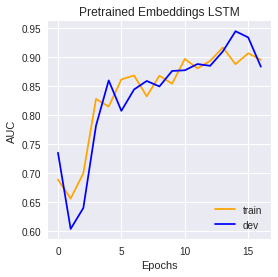

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = np.array(range(len(train_set_auc))) + 1
plt.figure(figsize=(4,4))
plt.plot(range(len(train_set_auc)), train_set_auc, color = "orange", label='train')
plt.plot(range(len(dev_set_auc)), dev_set_auc, color = "blue", label='dev')
plt.legend(loc='lower right')
plt.title('Pretrained Embeddings LSTM')
plt.xlabel('Epochs')
plt.ylabel('AUC')
# plt.ylim((-0.05, 1.05))
plt.show()

fn = 'Pretrained Embeddings LSTM.png'
plt.savefig(fn)
from google.colab import files
files.download(fn) 

How does it go on the test data?

In [0]:
# net_1 = LSTM(input_dim=100, hidden_dim=50, batch_size=1, output_dim=1, num_layers=1).cuda()

# net_1.load_state_dict(torch.load('pretrained_embeddings_sentence_average_20'))

get_dataset_auc(imdb_data_sentence['test'], net, len(imdb_data_sentence['test']['sentences']))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.9091345536000001

In [0]:
def predict_review(review, net):
    review = review.split(' ')
    se = sentence_embedding(review, word_vectors).cuda()

    net.hidden = net.init_hidden()
    pred = net(se)
    
    if pred > 0.5:
        print('a positive review')
    else:
        print('a negative review')
    
    return pred

In [0]:
review = 'It was good.'
predict_review(review, net)

a positive review


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.6294], device='cuda:0', grad_fn=<ViewBackward>)

In [0]:
review = 'It was not good.'
predict_review(review, net)

a negative review


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.3356], device='cuda:0', grad_fn=<ViewBackward>)

In [0]:
review = 'That was the best movie I have ever seen in my entire life.'
predict_review(review, net)

a positive review


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.8363], device='cuda:0', grad_fn=<ViewBackward>)

In [0]:
review = 'That film sucked! What a waste of time.'
predict_review(review, net)

a negative review


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.0014], device='cuda:0', grad_fn=<ViewBackward>)

Compare predictions to the training data

In [0]:
step += 1
text = imdb_data_sentence['train']['sentences'][step].cuda()
l = torch.Tensor([imdb_data_sentence['train']['labels'][step]]).cuda()

net.hidden = net.init_hidden()
pred = net(text)  
print(pred)
print(l)
print(imdb_data['train'].examples[step].text)

tensor([0.9993], device='cuda:0', grad_fn=<ViewBackward>)
tensor([1.], device='cuda:0')
['I', 'watched', 'the', 'un', '-', 'aired', 'episodes', 'online', 'and', 'I', 'was', 'so', 'sad', 'that', 'the', 'show', 'wo', "n't", 'be', 'back', '.', 'It', 'had', 'the', 'best', 'cast', 'of', 'mature', ',', 'talented', 'actors', 'and', 'an', 'amazing', 'chemistry', '.', 'It', 'seemed', 'like', 'all', 'the', 'actors', 'are', 'personal', 'friends', 'in', 'real', 'life', '.', 'Towards', 'the', 'end', 'the', 'show', 'became', 'engaging', ',', 'sexy', 'and', 'highly', 'watchable', '.', 'Of', 'course', ',', 'some', 'of', 'the', 'story', 'lines', 'are', 'not', 'realistic', ',', 'so', 'what', '...', 'The', 'characters', 'are', 'all', 'likable', 'and', 'you', 'root', 'for', 'them', '.', 'The', 'show', 'reminded', 'me', 'a', 'cross', 'between', '2', 'other', 'favorites', ':', '"', 'Sex', 'and', 'the', 'City', '"', 'and', '"', 'Felicity', '"', '.', 'Big', 'kudos', 'to', 'all', 'the', 'cast', '.', 'Note', 't

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
